# DeepExplainer Genomics Example

This runs DeepExplainer with the model trained on simulated genomic data from the DeepLIFT repo (https://github.com/kundajelab/deeplift/blob/master/examples/genomics/genomics_simulation.ipynb), using a dynamic reference (i.e. the reference varies depending on the input sequence; in this case, the reference is a collection of dinucleotide-shuffled versions of the input sequence)

The simulated data was as follows:

* 1/4 sequences with BOTH 1-3 instances of a GATA_disc1 motif AND 1-3 instances of a TAL1_known1 motif; these were labelled 1,1,1
* 1/4 sequences with 1-3 instances of a GATA_disc1 motif embedded; these were labelled 0,1,0
* 1/4 sequences with 1-3 instances of a TAL1_known1 motif embedded; these were labelled 0,0,1
* 1/4 sequences with no motif; these were labelled 0,0,0

In [1]:
%matplotlib inline

### Obtain data and keras model

Pull in the relevant data

In [2]:
! [[ ! -f sequences.simdata.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/db919b12f750e5844402153233249bb3d24e9e9a/deeplift/genomics/sequences.simdata.gz
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelJson.json ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelJson.json
! [[ ! -f keras2_conv1d_record_5_model_PQzyq_modelWeights.h5 ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/b6e1d69/deeplift/genomics/keras2_conv1d_record_5_model_PQzyq_modelWeights.h5
! [[ ! -f test.txt.gz ]] && wget https://raw.githubusercontent.com/AvantiShri/model_storage/9aadb769735c60eb90f7d3d896632ac749a1bdd2/deeplift/genomics/test.txt.gz

Load the data

In [3]:
! pip install simdna

In [4]:
import gzip

import simdna.synthetic as synthetic

data_filename = "sequences.simdata.gz"

# read in the data in the testing set
test_ids_fh = gzip.open("test.txt.gz", "rb")
ids_to_load = [x.decode("utf-8").rstrip("\n") for x in test_ids_fh]
data = synthetic.read_simdata_file(data_filename, ids_to_load=ids_to_load)

In [5]:
import numpy as np


# this is set up for 1d convolutions where examples
# have dimensions (len, num_channels)
# the channel axis is the axis for one-hot encoding.
def one_hot_encode_along_channel_axis(sequence):
    to_return = np.zeros((len(sequence), 4), dtype=np.int8)
    seq_to_one_hot_fill_in_array(
        zeros_array=to_return, sequence=sequence, one_hot_axis=1
    )
    return to_return


def seq_to_one_hot_fill_in_array(zeros_array, sequence, one_hot_axis):
    assert one_hot_axis in (0, 1)
    if one_hot_axis == 0:
        assert zeros_array.shape[1] == len(sequence)
    elif one_hot_axis == 1:
        assert zeros_array.shape[0] == len(sequence)
    # will mutate zeros_array
    for i, char in enumerate(sequence):
        if char in ("A", "a"):
            char_idx = 0
        elif char in ("C", "c"):
            char_idx = 1
        elif char in ("G", "g"):
            char_idx = 2
        elif char in ("T", "t"):
            char_idx = 3
        elif char in ("N", "n"):
            continue  # leave that pos as all 0's
        else:
            raise RuntimeError("Unsupported character: " + str(char))
        if one_hot_axis == 0:
            zeros_array[char_idx, i] = 1
        elif one_hot_axis == 1:
            zeros_array[i, char_idx] = 1


onehot_data = np.array(
    [one_hot_encode_along_channel_axis(seq) for seq in data.sequences]
)

Load the model

In [6]:
from keras.models import model_from_json

# load the keras model
keras_model_weights = "keras2_conv1d_record_5_model_PQzyq_modelWeights.h5"
keras_model_json = "keras2_conv1d_record_5_model_PQzyq_modelJson.json"

keras_model = model_from_json(open(keras_model_json).read())
keras_model.load_weights(keras_model_weights)

Install the deeplift package for the dinucleotide shuffling and visualization code

In [7]:
!pip install deeplift

### Compute importance scores

Define the function that generates the reference, in this case by performing a dinucleotide shuffle of the given input sequence

In [8]:
from deeplift.dinuc_shuffle import dinuc_shuffle


def shuffle_several_times(s):
    s = np.squeeze(s)
    return dinuc_shuffle(s, num_shufs=100)

Run DeepExplainer with the dynamic reference function

In [9]:
import shap

np.random.seed(1)

seqs_to_explain = onehot_data[[0, 3, 9]]  # these three are positive for task 0
dinuc_shuff_explainer = shap.DeepExplainer(
    (keras_model.input, keras_model.output[:, 0]), shuffle_several_times
)
raw_shap_explanations = dinuc_shuff_explainer.shap_values(
    seqs_to_explain, check_additivity=False
)

### Visualize scores on individual sequences

Scores for example 0


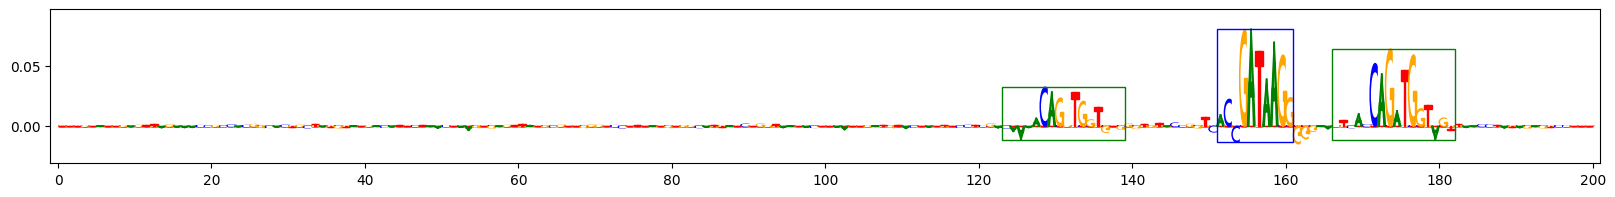

Scores for example 3


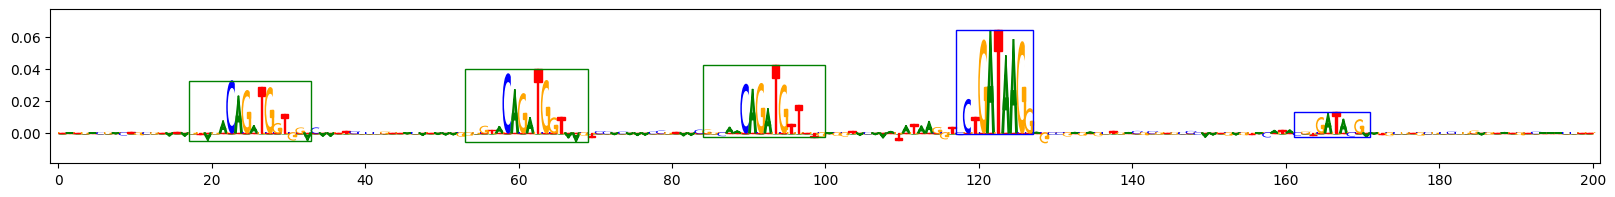

Scores for example 9


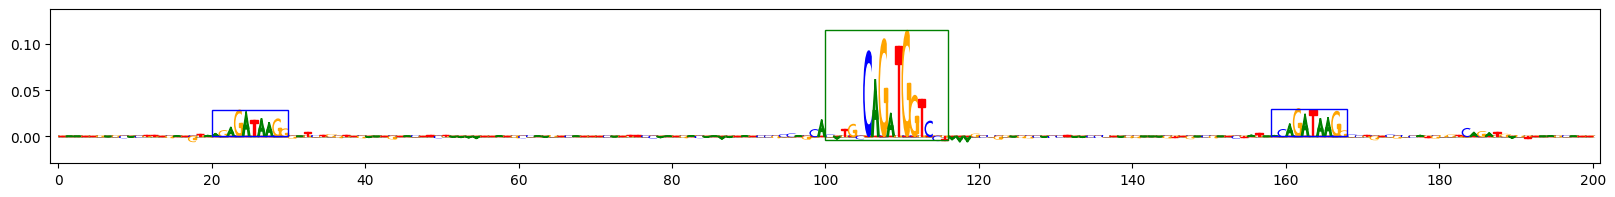

In [10]:
from deeplift.visualization import viz_sequence

# project the importance at each position onto the base that's actually present
dinuc_shuff_explanations = (
    np.sum(raw_shap_explanations, axis=-1)[:, :, None] * seqs_to_explain
)
for idx, dinuc_shuff_explanation in zip([0, 3, 9], dinuc_shuff_explanations):
    print("Scores for example", idx)
    highlight = {
        "blue": [
            (embedding.startPos, embedding.startPos + len(embedding.what))
            for embedding in data.embeddings[idx]
            if "GATA_disc1" in embedding.what.getDescription()
        ],
        "green": [
            (embedding.startPos, embedding.startPos + len(embedding.what))
            for embedding in data.embeddings[idx]
            if "TAL1_known1" in embedding.what.getDescription()
        ],
    }
    viz_sequence.plot_weights(
        dinuc_shuff_explanation, subticks_frequency=20, highlight=highlight
    )

The plots above show the importance scores for three example sequences on the task that predicts sequences containing both GATA_disc1 and TAL1_known1 motifs. Letter height reflects the score. Blue boxes indicate the ground-truth locations of the inserted GATA_disc1 motifs, green boxes indicate the ground-truth locations of the inserted TAL1_known1 motifs.